In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import galsim
import time
import math
import numpy as np

### Reading and visualizing images

In [5]:
def read_header_and_data(file_path, idx):
    with fits.open(file_path) as hdu:  
        header = hdu[idx].header
        data = hdu[idx].data
        
        return header, data

def show_image(image_data):
    plt.figure()
    plt.imshow(image_data, cmap='gray')
    plt.colorbar()

In [6]:
catalog_dir = 'galaxy_images/COSMOS_23.5_training_sample/'
catalog_name = 'real_galaxy_catalog_23.5.fits'
catalog_path = catalog_dir + catalog_name

In [7]:
h_catalog, d_catalog = read_header_and_data(catalog_path, 1)

In [8]:
header, image = read_header_and_data('galaxy_images/COSMOS_23.5_training_sample/real_galaxy_images_23.5_n1.fits', 1)

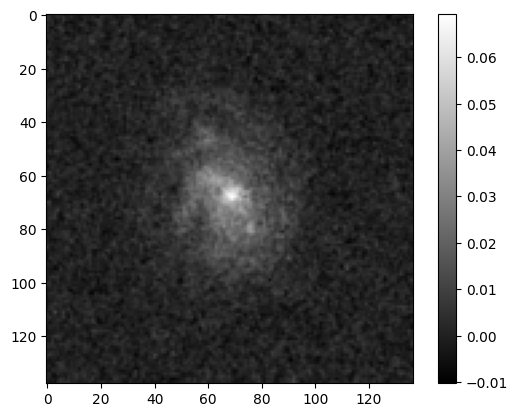

In [9]:
show_image(image)

### Simulating galaxy images with galsim

#### Secondary functions

In [10]:
def get_random_fwhm(initial_fwhms):
    fwhms = np.linspace(initial_fwhms[0], initial_fwhms[-1], 100)
    return np.random.choice(fwhms)

def compute_shear(shear_value, random_number):
    shear_beta = 2*math.pi * random_number * galsim.radians
    shear = galsim.Shear(g=shear_value, beta=shear_beta)

    return shear, shear_beta

In [11]:
rgc_cosmos = galsim.RealGalaxyCatalog(catalog_name, dir=catalog_dir)

### Galsim params

In [36]:
random_seed = galsim.BaseDeviate(11235813).raw()
pixel_scale = 0.2 # from paper
sky_level = 350 # ADU / pixel (1.e6  # ADU / arcsec^2 from paper using ADU/arcsec^2 = ADU/pixel * pixel_scale^2 TODO)
lens_shear_unifdist = np.random.uniform(0.01, 0.05)
atmos_shear_unifdist = np.random.uniform(0.01, 0.03)
fwhms = np.array([0.49, 0.62, 0.66, 0.78, 0.83]) # (Mandelbaum 2014)

### Generating images

In [57]:
idx = 1
rng = galsim.UniformDeviate(random_seed)
rng_base = galsim.BaseDeviate(random_seed)
galaxy = galsim.RealGalaxy(rgc_cosmos, index=idx)

# Random rotation
theta = 2*math.pi * rng() * galsim.radians
galaxy = galaxy.rotate(theta)

# Random shear
lens_shear, lens_shear_beta = compute_shear(lens_shear_unifdist, rng())
galaxy = galaxy.shear(g1=lens_shear.g1, g2=lens_shear.g2)

# Random lensing (maybe)
#galaxy = galaxy.lens(g1=lens_shear.g1, g2=lens_shear.g2, mu=1.3)

#galaxy = galaxy.magnify(mu=1.082) # from demo6

# Original galaxy from Hubble Space Telescope
psf_hst = rgc_cosmos.getPSF(idx)
galaxy_hst = galsim.Convolve([galaxy, psf_hst])

# Atmospheric PSF
fwhm = get_random_fwhm(fwhms)
atmospheric_psf = galsim.Kolmogorov(fwhm=fwhm, flux=1)
# Adding random shear and rotation to atmospheric PSF
atmos_shear, atmos_shear_beta = compute_shear(atmos_shear_unifdist, rng())
atmospheric_psf = atmospheric_psf.shear(g1=atmos_shear.g1, g2=atmos_shear.g2)
atmos_theta = 2*math.pi * rng() * galsim.radians
atmospheric_psf = atmospheric_psf.rotate(atmos_theta)

# Optical PSF
optical_psf = galsim.OpticalPSF(lam=651, # (Mandelbaum 2014) 
                                diam=8.4, # LSST primary mirror diameter in m
                                flux=1,
                                defocus=0.36*rng(),
                                obscuration=0.07*rng(),
                                coma1=0.07*rng(),
                                coma2=0.07*rng(),
                                astig1=0.07*rng(),
                                astig2=0.07*rng())


# Convolving both PSFs to get final PSF
final_psf = galsim.Convolve([atmospheric_psf, optical_psf])

# Convolve galaxy image with PSF
galaxy = galsim.Convolve([galaxy_hst, final_psf])


# Draw final image
img = galaxy_hst.drawImage(scale=pixel_scale)

# Add backgorund level
background = sky_level #* pixel_scale**2
img += background

# Write image to file
galsim.fits.write(img, 'final.fits')

In [56]:
u = galsim.UniformDeviate(12345)
for _ in range(10):
    print(u())

0.8286565493326634
0.9814489581622183
0.20402739313431084
0.6484564498532563
0.4912384550552815
0.8238709927536547
0.7893730385694653
0.26376558444462717
0.52878373186104
0.37646577041596174


### Reading image

#### Visualizing images

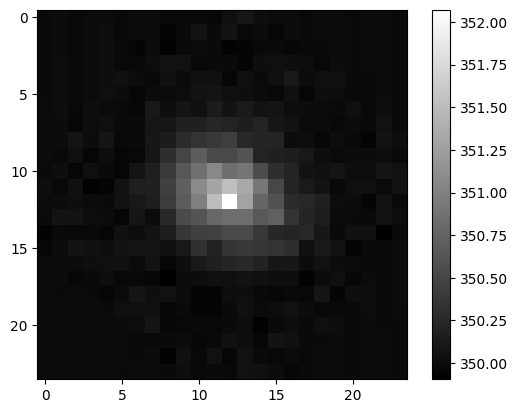

In [58]:
ihead, idata = read_header_and_data('final.fits', 0)
show_image(idata)

#### Visualizing demo images

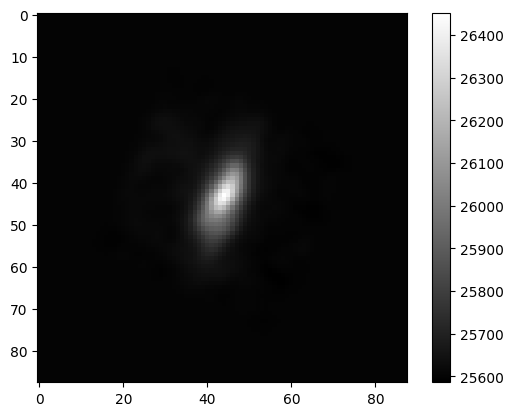

In [47]:
ihead, idata = read_header_and_data('output/cube_real.fits', 0)
show_image(idata[0])


### Getting original image